In [157]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, List, Tuple
from pprint import pprint
from tqdm import tqdm
import time
import datetime
import hashlib
from scipy import stats
import shap

from itertools import combinations, product

import missingno as msno
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GroupKFold, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.utils.validation import check_is_fitted

from BorutaShap import BorutaShap
import category_encoders as ce

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, EFeaturesSelectionAlgorithm, EShapCalcType
import xgboost as xgb

import optuna
from optuna.samplers import TPESampler

from utils import *
import gc
gc.enable()

In [2]:
seed = 42
np.random.seed(seed)
np.set_printoptions(2)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

TARGET = 'isFraud'

In [3]:
train = pd.read_csv('fraud_train.csv')
test = pd.read_csv('fraud_test.csv')

In [4]:
train, test = check_duplicates_and_constants(train, test)

Initial train shape: (180000, 394)
Initial test shape: (100001, 394)
Duplicates in train: 0
Duplicates in test: 0
V107 in train set is constant, removed both from train and test sets.
Final train shape: (180000, 393) , test shape: (100001, 393).


In [5]:
check_missings(train)

Total NA-values = 28186929


,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V284,V285,V286,V287,V290,V291,V292,V293,V294,V295,V297,V298,V299,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
Total,2611,3,8,953,7,19433,19433,119395,165542,28440,119700,99698,96962,73073,111244,155764,168324,146404,146404,45665,120901,159196,161333,159456,48819,118251,118251,118251,96724,118297,74348,148348,148348,148348,120901,120901,120901,120901,120901,120901,120901,120901,120901,120901,120901,45678,45678,45678,45678,45678,45678,45678,45678,45678,45678,45678,45678,45678,45678,45678,45678,45678,45678,45678,45678,45678,45678,45678,73079,73079,73079,73079,73079,73079,73079,73079,73079,73079,73079,73079,73079,73079,73079,73079,73079,73079,45911,45911,45911,45911,45911,45911,45911,45911,45911,45911,45911,45911,45911,45911,45911,45911,45911,45911,45911,45911,45911,45911,48827,48827,48827,48827,48827,48827,48827,48827,48827,48827,48827,48827,48827,48827,48827,48827,48827,48827,48827,48827,132174,132174,132174,132174,132174,132174,132174,132174,132174,132174,132174,132174,132174,132174,132174,132174,132174,132174,132174,132174,132174,132174,132174,132174,132174,132174,132174,132174,132174,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,115591,117995,117995,117995,114356,114356,114356,117995,117995,117995,117995,114356,117995,117995,117995,117995,117995,117995,114356,117995,117995,117995,114356,114356,117995,117995,117995,117995,117995,114356,117995,117995,117995,117995,114356,114356,117995,117995,117995,114356,114356,117995,117995,114356,117995,117995,117995,117995,117995,117995,117995,117995,117995,117995,114356,114356,114356,117995,117995,117995,117995,117995,117995,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,132004,132004,132004,132004,132004,132004,132004,132004,132004,132004,132004,132004,132004,132004,132004,132004,132004,132004
Percent,1.4506,0.0017,0.0044,0.5294,0.0039,10.7961,10.7961,66.3306,91.9678,15.8000,66.5000,55.3878,53.8678,40.5961,61.8022,86.5356,93.5133,81.3356,81.3356,25.3694,67.1672,88.4422,89.6294,88.5867,27.1217,65.6950,65.6950,65.6950,53.7356,65.7206,41.3044,82.4156,82.4156,82.4156,67.1672,67.1672,67.1672,67.1672,67.1672,67.1672,67.1672,67.1672,67.1672,67.1672,67.1672,25.3767,25.3767,25.3767,25.3767,25.3767,25.3767,25.3767,25.3767,25.3767,25.3767,25.3767,25.3767,25.3767,25.3767,25.3767,25.3767,25.3767,25.3767,25.3767,25.3767

In [10]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,177389.0000,179997.0000,179047.0000,160567.0000,160567.0000,60605.0000,14458.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,80302.0000,83038.0000,106927.0000,68756.0000,24236.0000,11676.0000,33596.0000,33596.0000,134335.0000,59099.0000,20804.0000,18667.0000,20544.0000,131181.0000,59099.0000,59099.0000,59099.0000,59099.0000,59099.0000,59099.0000,59099.0000,59099.0000,59099.0000,59099.0000,59099.0000,134322.0000,134322.0000,134322.0000,134322.0000,134322.0000,134322.0000,134322.0000,134322.0000,134322.0000,134322.0000,134322.0000,134322.0000,134322.0000,134322.0000,134322.0000,134322.0000,134322.0000,134322.0000,134322.0000,134322.0000,134322.0000,134322.0000,134322.0000,106921.0000,106921.0000,106921.0000,106921.0000,106921.0000,106921.0000,106921.0000,106921.0000,106921.0000,106921.0000,106921.0000,106921.0000,106921.0000,106921.0000,106921.0000,106921.0000,106921.0000,106921.0000,134089.0000,134089.0000,134089.0000,134089.0000,134089.0000,134089.0000,134089.0000,134089.0000,134089.0000,134089.0000,134089.0000,134089.0000,134089.0000,134089.0000,134089.0000,134089.0000,134089.0000,134089.0000,134089.0000,134089.0000,134089.0000,134089.0000,131173.0000,131173.0000,131173.0000,131173.0000,131173.0000,131173.0000,131173.0000,131173.0000,131173.0000,131173.0000,131173.0000,131173.0000,131173.0000,131173.0000,131173.0000,131173.0000,131173.0000,131173.0000,131173.0000,131173.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,180000.0000,47826.0000,47826.0000,47826.0000,47826.0000,47826.0000,47826.0000,47826.0000,47826.0000,47826.0000,47826.0000,4782

In [9]:
train.describe(include="object")

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
count,180000,179992,179993,151560,60300,61749,61749,61749,83276,61703,105652,31652,31652,31652
unique,5,4,4,59,60,2,2,2,3,2,2,2,2,2
top,W,visa,debit,gmail.com,gmail.com,T,T,T,M0,F,F,F,F,T
freq,110340,118295,122746,67198,24644,61748,55657,48603,51229,34262,56627,27118,19814,26970


In [5]:
numerical_columns = [column for column in train.columns[2:,] if train[column].dtype not in ["object", "category"]]
categorical_columns = [column for column in train.columns[2:,] if column not in numerical_columns]

In [6]:
train[TARGET].value_counts(normalize=True)

0   0.9714
1   0.0286
Name: isFraud, dtype: float64

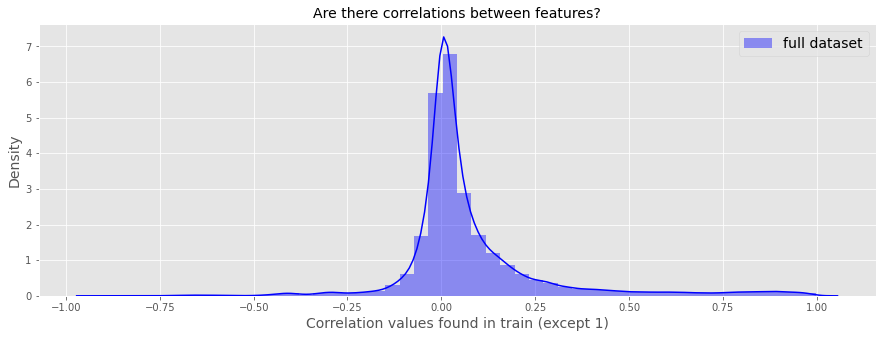

In [17]:
show_correlation_hist(train, columns=train.columns[2:])

In [6]:
def card_info_hash(x):
    s = (str(x['card1'])+
         str(x['card2'])+
         str(x['card3'])+
         str(x['card4'])+
         str(x['card5'])+
         str(x['card6'])+
         x["ProductCD"]
    )

    h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]  # this is not necessary, we get same unique users without hash
    return h

train = reduce_memory_df(train)
test = reduce_memory_df(test)

train['card_hash'] = train.apply(lambda x: card_info_hash(x), axis=1)
test['card_hash'] = test.apply(lambda x: card_info_hash(x), axis=1)
train = train.sort_values('card_hash')

print(f"Train unique users: {train['card_hash'].nunique()}, test users: {test['card_hash'].nunique()}")
print(f"Users from test in train: {len(set(train['card_hash']) & set(test['card_hash']))}")

Train unique users: 14871, test users: 8723
Users from test in train: 5803


In [7]:
X, y = train.drop([TARGET, 'TransactionID'], axis=1), train[TARGET]
categorical_indices = [i for i, column in enumerate(X.columns[:-1]) if X[column].dtype in ["object", "category"]]

# del train; 
gc.collect()
# encoders = []
# for column in categorical_columns:
#     encoder = LabelEncoder()
#     X[column] = encoder.fit_transform(X[column])
#     encoders.append(encoder)

0

**split by time**

In [59]:
# split by synthetic user_id
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=117028, shuffle=False, random_state=seed)
x_test, x_valid, y_test, y_valid= train_test_split(x_test, y_test, train_size=31498, shuffle=False, random_state=seed)
print(f"Train size: {len(x_train)}, validation size: {len(x_valid)}, test size: {len(x_test)}.")

#check_split_equality(x_train.drop('card_hash', axis=1), x_valid.drop('card_hash', axis=1), categorical=categorical_indices)
#check_split_equality(x_train.drop('card_hash', axis=1), x_test.drop('card_hash', axis=1), categorical=categorical_indices)
gc.collect()
# we got cv-score >> 0.5, when desirebale is 0.5. This happened because "TransactionDT" is different in train and test sets
# so it became almost perfect predictor (as after some value (tree-split) we always have label 1 and before it - 0)

Train size: 117028, validation size: 31474, test size: 31498.


895

**split by similarity of train and test samples + user_id where acceptable**

In [8]:
# reassign splits
to_drop = [TARGET, 'TransactionID', 'card_hash', 'TransactionDT']
x_adv = pd.concat([train.drop(to_drop, axis=1), test.drop(to_drop, axis=1)], axis=0)
x_adv = x_adv.reset_index(drop=True)
x_adv = reduce_memory_df(x_adv)

y_adv = np.hstack((np.zeros(X.shape[0]), np.ones(test.shape[0])))
y_adv = pd.Series(y_adv)

adv_params = {
              'metric':"auc", 
              'boosting_type': 'gbdt',
              'n_estimators': 2000,
              'reg_alpha': 0.436193,
              'reg_lambda': 0.479169,
              'subsample': 0.7,
              'min_split_gain': 0.024766,
              'min_child_weight': 56,
              'subsample_for_bin': 240000,
              'colsample_bytree': 0.508716,
              'random_state': seed,
              'learning_rate': 0.01,
              'max_depth': 3,
              'num_leaves': 13,
              'is_unbalance': True,
             }

fold = KFold(n_splits=5, random_state=seed, shuffle=True)
_, oof_preds = lightgbm_cross_validation(adv_params, 
                                         x_adv, 
                                         y_adv, 
                                         cv=fold, 
                                         rounds=50,
                                         verbose=False)

In [9]:
oof_preds_train = oof_preds[:X.shape[0]]
assert oof_preds_train.shape[0] == X.shape[0]

bins = pd.cut(
    oof_preds_train, bins=np.arange(0, 1.01, 0.1)
)
bins.value_counts().sort_index()

(0.0, 0.1]    13950
(0.1, 0.2]    47868
(0.2, 0.3]    48621
(0.3, 0.4]    31593
(0.4, 0.5]    14852
(0.5, 0.6]    11862
(0.6, 0.7]     6380
(0.7, 0.8]     4516
(0.8, 0.9]      235
(0.9, 1.0]      123
dtype: int64

In [72]:
oof_preds_train = pd.Series(oof_preds_train)  # take most similar to test samples based on probability
test_objects_mask = oof_preds_train >= 0.5
x_test = train.loc[test_objects_mask]
print(x_test.shape)

x_train, x_valid = train_test_split(train.drop(x_test.index, axis=0).sort_values('card_hash'), 
                                    train_size=125556, shuffle=False, random_state=seed)  # base: shuffle True + remove sorting

(23116, 394)


In [73]:
x_train, y_train = x_train.drop([TARGET, 'TransactionID', 'card_hash'], axis=1), x_train[TARGET]
x_valid, y_valid = x_valid.drop([TARGET, 'TransactionID', 'card_hash'], axis=1), x_valid[TARGET]
x_test, y_test = x_test.drop([TARGET, 'TransactionID', 'card_hash'], axis=1), x_test[TARGET]

print(f"Train size: {len(x_train)}, validation size: {len(x_valid)}, test size: {len(x_test)}.")

Train size: 125556, validation size: 31328, test size: 23116.


In [79]:
adv_params = {
              'metric':"auc", 
              'boosting_type': 'gbdt',
              'n_estimators': 2000,
              'reg_alpha': 0.436193,
              'reg_lambda': 0.479169,
              'subsample': 0.7,
              'min_split_gain': 0.024766,
              'min_child_weight': 56,
              'subsample_for_bin': 240000,
              'colsample_bytree': 0.508716,
              'random_state': seed,
              'learning_rate': 0.01,
              'max_depth': 3,
              'num_leaves': 13,
              'is_unbalance': True,
             }

fold = KFold(n_splits=5, random_state=seed, shuffle=True)
# fold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
# fold = TimeSeriesSplit(n_splits=5)
# fold = GroupKFold(n_splits=5)  # groups=train['card_hash']

est, oof_scores = lightgbm_cross_validation(adv_params, 
                                            train.drop([TARGET, 'TransactionID', 'card_hash'], axis=1), 
                                            train[TARGET], 
                                            cv=fold, 
                                            rounds=50)
# del est; 
gc.collect()

Fri Sep  2 15:12:40 2022, Cross-Validation, 180000 rows, 391 cols
Fold 1, Train score = 0.93370, Valid score = 0.91574
Fold 2, Train score = 0.93387, Valid score = 0.91760
Fold 3, Train score = 0.93310, Valid score = 0.91945
Fold 4, Train score = 0.93481, Valid score = 0.90955
Fold 5, Train score = 0.93242, Valid score = 0.92257
Train score by each fold: [0.9337, 0.93387, 0.9331, 0.93481, 0.93242]
Valid score by each fold: [0.91574, 0.9176, 0.91945, 0.90955, 0.92257]
Train mean score by each fold:0.93358 +/- 0.00080
Valid mean score by each fold:0.91698 +/- 0.00435
**************************************************
OOF-score: 0.50340


4366

In [ ]:
# simple arithmetic mean
# y_train_probs = np.array([model.predict_proba(x_train)[:,1] for model in est]).T.mean(axis=1)
# y_valid_probs = np.array([model.predict_proba(x_valid)[:,1] for model in est]).T.mean(axis=1)
# y_test_probs = np.array([model.predict_proba(x_test)[:,1] for model in est]).T.mean(axis=1)
# get_best_threshold(y_valid, y_valid_probs)

In [64]:
# report(y_train, y_train_probs>=0.8151576971909181, y_test, y_test_probs>=0.8151576971909181, y_train_probs, y_test_probs)
# using single CV model take care of not overfitting its base estimators here

Train
               precision    recall  f1-score   support

           0     0.9870    0.9888    0.9879    113521
           1     0.6154    0.5780    0.5961      3507

    accuracy                         0.9765    117028
   macro avg     0.8012    0.7834    0.7920    117028
weighted avg     0.9759    0.9765    0.9762    117028

Test
               precision    recall  f1-score   support

           0     0.9856    0.9887    0.9872     30566
           1     0.5885    0.5279    0.5566       932

    accuracy                         0.9751     31498
   macro avg     0.7871    0.7583    0.7719     31498
weighted avg     0.9739    0.9751    0.9745     31498

Train ROC_AUC: 0.938, Test ROC_AUC: 0.897
Train GINI: 0.876, Test GINI: 0.794


In [65]:
# calc CI on x_test and compare to test dataset: LB is out of CI which is sad
# calculate_confidence_interval(create_bootstrap_metrics(y_test, y_test_probs, roc_auc_score))

(0.8839504449524103, 0.9085001215990658)

In [80]:
test_lb = np.array([model.predict_proba(test.drop([TARGET, 'TransactionID', 'card_hash'], 
                                                  axis=1))[:,1] for model in est]).T.mean(axis=1)

In [81]:
roc_auc_score(test[TARGET], test_lb)  # not in CI 

0.8652170282423095

**Feature processing & engineering**

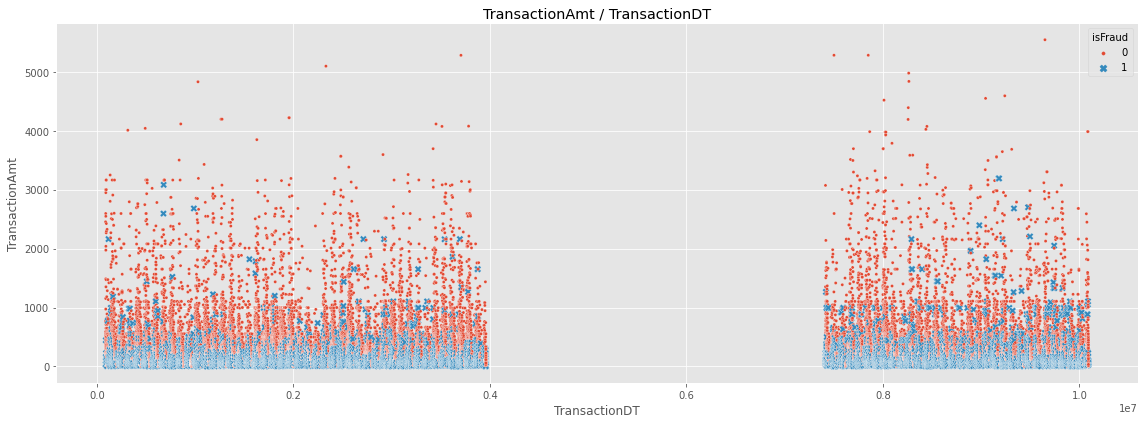

In [25]:
plt.figure(figsize=(16, 6))
plt.title("TransactionAmt / TransactionDT")
sns.scatterplot(x="TransactionDT", y="TransactionAmt", hue=TARGET, data=pd.concat([train, test], axis=0), style=TARGET,
                size=TARGET, sizes=(50, 10))
plt.tight_layout()
plt.show()
# so we see that fraud transactions have lower amount and train/test are separated by time

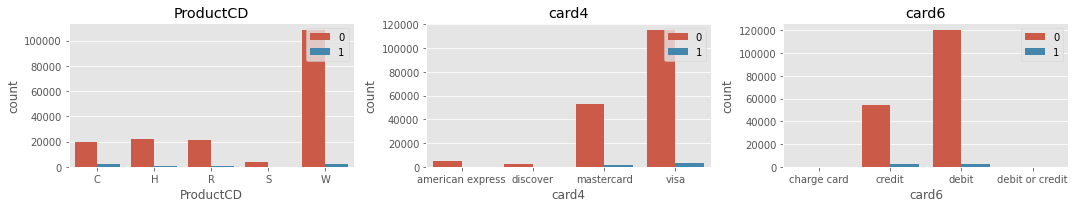

In [109]:
countplot(pd.merge(X, y, right_index=True, left_index=True)[["ProductCD", "card4", "card6", TARGET]], TARGET)

In [308]:
factor_a = train["TransactionAmt"].sample(1000, random_state=seed).fillna(0)
factor_b = test["TransactionAmt"].sample(1000, random_state=seed).fillna(0)
print(pd.concat([factor_a, factor_b], axis=1).corr())
print(stats.shapiro(factor_a))
print(stats.shapiro(factor_b))
print(stats.ttest_ind(factor_a.sample(100), factor_b.sample(100), equal_var=False))
print(stats.ks_2samp(factor_a, factor_b))
stats.mannwhitneyu(factor_a, factor_b)
# H0 hypothesis accepted that two means are statistically equal

                TransactionAmt  TransactionAmt
TransactionAmt          1.0000         -0.2072
TransactionAmt         -0.2072          1.0000
ShapiroResult(statistic=0.4873250126838684, pvalue=0.0)
ShapiroResult(statistic=0.4236631393432617, pvalue=0.0)
Ttest_indResult(statistic=-0.9320091764790549, pvalue=0.3528436470683757)
KstestResult(statistic=0.055, pvalue=0.09710349657052789)


MannwhitneyuResult(statistic=479973.0, pvalue=0.12085213963978828)

**Assume we have test set comming in real time, so we cannot use its statistics (model already trained)**

In [7]:
train["TransactionDT"] = pd.Timestamp('2017-12-01') + pd.to_timedelta(train["TransactionDT"], unit='s')
test["TransactionDT"] = pd.Timestamp('2017-12-01') + pd.to_timedelta(test["TransactionDT"], unit='s')

In [8]:
train["TransactionYear"] = train["TransactionDT"].dt.year.astype("category")
train["TransactionMonth"] = train["TransactionDT"].dt.month.astype("category")
train["TransactionDayWeek"] = train["TransactionDT"].dt.dayofweek.astype("category")
train["TransactionHour"] = train["TransactionDT"].dt.hour.astype("category")
train["TransactionDay"] = train["TransactionDT"].dt.day.astype("category")

test["TransactionYear"] = test["TransactionDT"].dt.year.astype("category")
test["TransactionMonth"] = test["TransactionDT"].dt.month.astype("category")
test["TransactionDayWeek"] = test["TransactionDT"].dt.dayofweek.astype("category")
test["TransactionHour"] = test["TransactionDT"].dt.hour.astype("category")
test["TransactionDay"] = test["TransactionDT"].dt.day.astype("category")

In [9]:
train["card1_2"] = (train["card1"].apply(str) + '_' + train["card2"].apply(str)).astype("category")
train["card1_2_3_5"] = (train["card1"].apply(str) + '_' + train["card2"].apply(str) + '_' +\
                                                 train["card3"].apply(str) + '_' + train["card5"].apply(str))
train["card_addr"] = (train["card1_2_3_5"] + '_' + train["addr1"].apply(str) + '_' +\
                      train["addr2"].apply(str)).astype("category")
train["card1_2_3_5"] = train["card1_2_3_5"].astype("category")

test["card1_2"] = (test["card1"].apply(str) + '_' + test["card2"].apply(str)).astype("category")
test["card1_2_3_5"] = (test["card1"].apply(str) + '_' + test["card2"].apply(str) + '_' +\
                                                 test["card3"].apply(str) + '_' + test["card5"].apply(str))
test["card_addr"] = (test["card1_2_3_5"] + '_' + test["addr1"].apply(str) + '_' +\
                      test["addr2"].apply(str)).astype("category")
test["card1_2_3_5"] = test["card1_2_3_5"].astype("category")

In [10]:
cat_freq_features = ["card1", "card2", "card3", "card4", "card5", "card6", "addr1", "addr2"]
encoder = FrequencyEncoder(cat_freq_features)

train = encoder.fit_transform(train)
test = encoder.transform(test)

In [11]:
train_agg_amt_means, train_agg_amt_stds = {}, {}
for feature in cat_freq_features:
    train_agg_amt_means[feature] = train.groupby(feature)["TransactionAmt"].mean()
    train_agg_amt_stds[feature] = train.groupby(feature)["TransactionAmt"].std()
    
for feature in cat_freq_features:
    train[f"AMT_BY_{feature}_mean"] = train["TransactionAmt"] / train[feature].map(train_agg_amt_means.get(feature)).astype(float)
    train[f"AMT_BY_{feature}_diff"] = train["TransactionAmt"] - train[feature].map(train_agg_amt_means.get(feature)).astype(float)
    train[f"AMT_BY_{feature}_std"] = train["TransactionAmt"] / train[feature].map(train_agg_amt_stds.get(feature)).astype(float)
    
    test[f"AMT_BY_{feature}_mean"] = test["TransactionAmt"] / test[feature].map(train_agg_amt_means.get(feature)).astype(float)
    test[f"AMT_BY_{feature}_diff"] = test["TransactionAmt"] - test[feature].map(train_agg_amt_means.get(feature)).astype(float)
    test[f"AMT_BY_{feature}_std"] = test["TransactionAmt"] / test[feature].map(train_agg_amt_stds.get(feature)).astype(float)

In [12]:
train_agg_amt_means, train_agg_amt_stds = {}, {}
for feature in cat_freq_features:
    train_agg_amt_means[feature] = train.groupby(feature)["D15"].mean()
    train_agg_amt_stds[feature] = train.groupby(feature)["D15"].std()
# use train stats 
for feature in cat_freq_features:
    train[f"D15_BY_{feature}_mean"] = train["D15"] / train[feature].map(train_agg_amt_means.get(feature)).astype(float)
    train[f"D15_BY_{feature}_diff"] = train["D15"] - train[feature].map(train_agg_amt_means.get(feature)).astype(float)
    train[f"D15_BY_{feature}_std"] = train["D15"] / train[feature].map(train_agg_amt_stds.get(feature)).astype(float)
    
    test[f"D15_BY_{feature}_mean"] = test["D15"] / test[feature].map(train_agg_amt_means.get(feature)).astype(float)
    test[f"D15_BY_{feature}_diff"] = test["D15"] - test[feature].map(train_agg_amt_means.get(feature)).astype(float)
    test[f"D15_BY_{feature}_std"] = test["D15"] / test[feature].map(train_agg_amt_stds.get(feature)).astype(float)

In [13]:
train["INT_TransAmt"] = train["TransactionAmt"].astype(np.int16)
train["FL_TransAmt"] = train["TransactionAmt"] - train["INT_TransAmt"]
train["TransactionAmt_log"] = np.log(train["TransactionAmt"])

test["INT_TransAmt"] = test["TransactionAmt"].astype(np.int16)
test["FL_TransAmt"] = test["TransactionAmt"] - test["INT_TransAmt"]
test["TransactionAmt_log"] = np.log(test["TransactionAmt"])

In [14]:
encoder = FrequencyEncoder(["P_emaildomain", "R_emaildomain"])

train = encoder.fit_transform(train)
test = encoder.transform(test)

In [15]:
cols_d = [column for column in train.columns[:393] if column.startswith("D")]
cols_c = [column for column in train.columns[:393] if column.startswith("C")]
cols_v = [column for column in train.columns[:393] if column.startswith("V")]

In [16]:
train["D_mean"] = train[cols_d].mean(axis=1)
train["D_std"] = train[cols_d].std(axis=1)

train["C_mean"] = train[cols_c].mean(axis=1)
train["C_std"] = train[cols_c].std(axis=1)

train["V_mean"] = train[cols_v].mean(axis=1)
train["V_std"] = train[cols_v].std(axis=1)

test["D_mean"] = test[cols_d].mean(axis=1)
test["D_std"] = test[cols_d].std(axis=1)

test["C_mean"] = test[cols_c].mean(axis=1)
test["C_std"] = test[cols_c].std(axis=1)

test["V_mean"] = test[cols_v].mean(axis=1)
test["V_std"] = test[cols_v].std(axis=1)

In [17]:
pipe = make_pipeline(StandardScaler(), PCA(n_components=None, random_state=seed))

numerical_columns = [column for column in train.columns[3:] if train[column].dtype not in ["object", "category"]]

pca_features = pipe.fit_transform(train[numerical_columns].fillna(0).replace(np.inf, -1))
pca_features = pd.DataFrame(data=pca_features[:, :61], columns=[f"PCA_{i}" for i in range(1, 62)], index=train.index)

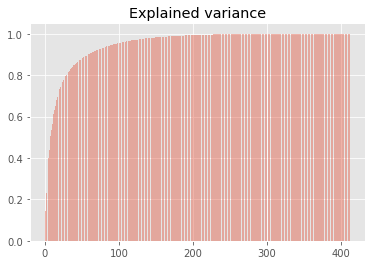

In [185]:
plt.title("Explained variance")
plt.bar(np.arange(1, 412), pipe[1].explained_variance_ratio_.cumsum(), alpha=0.4)
plt.show()

In [188]:
# pipe[1].explained_variance_ratio_.cumsum()[60]

0.9050035425711059

In [18]:
pca_test_features = pipe.transform(test[numerical_columns].fillna(0).replace(np.inf, -1))
pca_test_features = pd.DataFrame(data=pca_test_features[:, :61], columns=[f"PCA_{i}" for i in range(1, 62)], index=test.index)

In [19]:
train = pd.concat([train, pca_features], axis=1)
test = pd.concat([test, pca_test_features], axis=1)

In [20]:
aggs = {
    "TransactionAmt": ["mean", "sum", "count", "min", "max"]
}

trans_agg_train = create_numerical_aggs(train, groupby_id="card_hash", aggs=aggs, suffix="_BY_CARD_HASH")
# trans_agg_test = create_numerical_aggs(test, groupby_id="card_hash", aggs=aggs, suffix="_BY_CARD_HASH")

In [21]:
train = pd.merge(train, trans_agg_train, on="card_hash", how='left')
test = pd.merge(test, trans_agg_train, on="card_hash", how="left")  # alternative: trans_agg_test!

**Hypothesis that test data should contain and accumulate train dataset statistics**

In [22]:
test_card_ids = test["card_hash"].unique()
train_card_ids = train["card_hash"].unique()
common_ids = list(set(test_card_ids) & set(train_card_ids))

In [23]:
train_mean_hash = train.loc[train["card_hash"].isin(common_ids), ["card_hash", "TRANSACTIONAMT_MEAN_BY_CARD_HASH"]].groupby("card_hash").max().reset_index()
test_mean_hash = test.loc[test["card_hash"].isin(common_ids), ["card_hash", "TRANSACTIONAMT_MEAN_BY_CARD_HASH"]].groupby("card_hash").max().reset_index()

train_sum_hash = train.loc[train["card_hash"].isin(common_ids), ["card_hash", "TRANSACTIONAMT_SUM_BY_CARD_HASH"]].groupby("card_hash").max().reset_index()
test_sum_hash = test.loc[test["card_hash"].isin(common_ids), ["card_hash", "TRANSACTIONAMT_SUM_BY_CARD_HASH"]].groupby("card_hash").max().reset_index()

train_count_hash = train.loc[train["card_hash"].isin(common_ids), ["card_hash", "TRANSACTIONAMT_COUNT_BY_CARD_HASH"]].groupby("card_hash").max().reset_index()
test_count_hash = test.loc[test["card_hash"].isin(common_ids), ["card_hash", "TRANSACTIONAMT_COUNT_BY_CARD_HASH"]].groupby("card_hash").max().reset_index()

train_min_hash = train.loc[train["card_hash"].isin(common_ids), ["card_hash", "TRANSACTIONAMT_MIN_BY_CARD_HASH"]].groupby("card_hash").max().reset_index()
test_min_hash = test.loc[test["card_hash"].isin(common_ids), ["card_hash", "TRANSACTIONAMT_MIN_BY_CARD_HASH"]].groupby("card_hash").max().reset_index()

train_max_hash = train.loc[train["card_hash"].isin(common_ids), ["card_hash", "TRANSACTIONAMT_MAX_BY_CARD_HASH"]].groupby("card_hash").max().reset_index()
test_max_hash = test.loc[test["card_hash"].isin(common_ids), ["card_hash", "TRANSACTIONAMT_MAX_BY_CARD_HASH"]].groupby("card_hash").max().reset_index()

In [24]:
test_mean_hash["TRANSACTIONAMT_MEAN_BY_CARD_HASH"] = (test_mean_hash["TRANSACTIONAMT_MEAN_BY_CARD_HASH"] * test_count_hash["TRANSACTIONAMT_COUNT_BY_CARD_HASH"] + train_mean_hash["TRANSACTIONAMT_MEAN_BY_CARD_HASH"] * train_count_hash["TRANSACTIONAMT_COUNT_BY_CARD_HASH"]) / (test_count_hash["TRANSACTIONAMT_COUNT_BY_CARD_HASH"] + train_count_hash["TRANSACTIONAMT_COUNT_BY_CARD_HASH"])
test_sum_hash["TRANSACTIONAMT_SUM_BY_CARD_HASH"] += train_sum_hash["TRANSACTIONAMT_SUM_BY_CARD_HASH"]
test_count_hash["TRANSACTIONAMT_COUNT_BY_CARD_HASH"] += train_count_hash["TRANSACTIONAMT_COUNT_BY_CARD_HASH"]
test_min_hash["TRANSACTIONAMT_MIN_BY_CARD_HASH"] = np.where(test_min_hash["TRANSACTIONAMT_MIN_BY_CARD_HASH"] < train_min_hash["TRANSACTIONAMT_MIN_BY_CARD_HASH"], test_min_hash["TRANSACTIONAMT_MIN_BY_CARD_HASH"], train_min_hash["TRANSACTIONAMT_MIN_BY_CARD_HASH"])
test_min_hash["TRANSACTIONAMT_MAX_BY_CARD_HASH"] = np.where(test_max_hash["TRANSACTIONAMT_MAX_BY_CARD_HASH"] > train_max_hash["TRANSACTIONAMT_MAX_BY_CARD_HASH"], test_min_hash["TRANSACTIONAMT_MIN_BY_CARD_HASH"], train_min_hash["TRANSACTIONAMT_MIN_BY_CARD_HASH"])

In [25]:
test_mean_hash = dict(zip(test_mean_hash["card_hash"], test_mean_hash["TRANSACTIONAMT_MEAN_BY_CARD_HASH"]))
test_sum_hash = dict(zip(test_sum_hash["card_hash"], test_sum_hash["TRANSACTIONAMT_SUM_BY_CARD_HASH"]))
test_count_hash = dict(zip(test_count_hash["card_hash"], test_count_hash["TRANSACTIONAMT_COUNT_BY_CARD_HASH"]))
test_min_hash = dict(zip(test_min_hash["card_hash"], test_min_hash["TRANSACTIONAMT_MIN_BY_CARD_HASH"]))
test_max_hash = dict(zip(test_max_hash["card_hash"], test_max_hash["TRANSACTIONAMT_MAX_BY_CARD_HASH"]))

In [26]:
condition = test["card_hash"].isin(common_ids)
test.loc[condition, "TRANSACTIONAMT_MEAN_BY_CARD_HASH"] = test.loc[condition, "card_hash"].map(test_mean_hash)
test.loc[condition, "TRANSACTIONAMT_SUM_BY_CARD_HASH"] = test.loc[condition, "card_hash"].map(test_sum_hash)
test.loc[condition, "TRANSACTIONAMT_COUNT_BY_CARD_HASH"] = test.loc[condition, "card_hash"].map(test_count_hash)
test.loc[condition, "TRANSACTIONAMT_MIN_BY_CARD_HASH"] = test.loc[condition, "card_hash"].map(test_min_hash)
test.loc[condition, "TRANSACTIONAMT_MAX_BY_CARD_HASH"] = test.loc[condition, "card_hash"].map(test_max_hash)

**End of hypothesis**

In [24]:
train_lags = make_lags(train.sort_values("TransactionDT").groupby("card_hash")["TransactionAmt"], lags=5, feature="TransactionAmt").sort_index()
test_lags = make_lags(test.sort_values("TransactionDT").groupby("card_hash")["TransactionAmt"], lags=5, feature="TransactionAmt").sort_index()

In [25]:
train = pd.merge(train, train_lags, right_index=True, left_index=True)
test = pd.merge(test, test_lags, right_index=True, left_index=True)

In [26]:
train.drop(["TransactionDT", "TransactionID", "card_hash"], axis=1, inplace=True)
test.drop(["TransactionDT", "TransactionID", "card_hash"], axis=1, inplace=True)
# to_drop_hash = [TARGET, "TransactionDT", "TransactionID", "card_hash"]
# to_drop_ = [TARGET, "TransactionDT", "TransactionID"]

**LGBM full/boruta/permutation + LDA data cross-validation**

In [27]:
adv_params = {
              'metric':"auc", 
              'boosting_type': 'gbdt',
              'n_estimators': 1000,
              'reg_alpha': 0.436193,
              'reg_lambda': 0.479169,
              'subsample': 0.3,
              'min_split_gain': 0.024766,
              'min_child_weight': 56,
              'subsample_for_bin': 240000,
              'colsample_bytree': 0.308716,
              'random_state': seed,
              'learning_rate': 0.0034,
              'max_depth': 3,
              'num_leaves': 13,
              'is_unbalance': True,
             }

fold = KFold(n_splits=5, random_state=seed, shuffle=True)

est, oof_scores = lightgbm_cross_validation(adv_params, 
                                            train.drop(TARGET, axis=1), 
                                            train[TARGET], 
                                            cv=fold, 
                                            rounds=50)
# del est; 
gc.collect()
# if CV was stable: learn with hold-out (or adversarial hold-out) and calculate CI to compare with LB
test_lb = np.array([model.predict_proba(test.drop(TARGET, axis=1))[:,1] for model in est]).T.mean(axis=1)
roc_auc_score(test[TARGET], test_lb)  # 0.8673 with card_hash hypothesis and 

Sun Sep  4 21:11:30 2022, Cross-Validation, 180000 rows, 526 cols
Fold 1, Train score = 0.94596, Valid score = 0.91253
Fold 2, Train score = 0.94333, Valid score = 0.92277
Fold 3, Train score = 0.94652, Valid score = 0.91641
Fold 4, Train score = 0.94479, Valid score = 0.92179
Fold 5, Train score = 0.94734, Valid score = 0.91074
Train score by each fold: [0.94596, 0.94333, 0.94652, 0.94479, 0.94734]
Valid score by each fold: [0.91253, 0.92277, 0.91641, 0.92179, 0.91074]
Train mean score by each fold:0.94559 +/- 0.00140
Valid mean score by each fold:0.91685 +/- 0.00481
**************************************************
OOF-score: 0.91678


0.863670163379571

In [35]:
adv_params = {
              'metric':"auc", 
              'boosting_type': 'goss',
              'n_estimators': 1000,
              'reg_alpha': 0.436193,
              'reg_lambda': 0.479169,
              'subsample': 0.3,
              'min_split_gain': 0.024766,
              'min_child_weight': 56,
              'subsample_for_bin': 240000,
              'colsample_bytree': 0.308716,
              'random_state': seed,
              'learning_rate': 0.0014,
              'max_depth': 5,
              'num_leaves': 18,
              'is_unbalance': True,
             }

fold = KFold(n_splits=5, random_state=seed//5, shuffle=True)

est2, oof_scores2 = lightgbm_cross_validation(adv_params, 
                                              train.drop(TARGET, axis=1)[deltas], 
                                              train[TARGET], 
                                              cv=fold, 
                                              rounds=50)

gc.collect()

test_lb2 = np.array([model.predict_proba(test.drop(TARGET, axis=1)[deltas])[:,1] for model in est2]).T.mean(axis=1)
roc_auc_score(test[TARGET], test_lb2) 

Sun Sep  4 21:56:11 2022, Cross-Validation, 180000 rows, 221 cols
Fold 1, Train score = 0.97010, Valid score = 0.94219
Fold 2, Train score = 0.97053, Valid score = 0.92904
Fold 3, Train score = 0.97002, Valid score = 0.93120
Fold 4, Train score = 0.96992, Valid score = 0.93628
Fold 5, Train score = 0.96992, Valid score = 0.94042
Train score by each fold: [0.9701, 0.97053, 0.97002, 0.96992, 0.96992]
Valid score by each fold: [0.94219, 0.92904, 0.9312, 0.93628, 0.94042]
Train mean score by each fold:0.97010 +/- 0.00023
Valid mean score by each fold:0.93583 +/- 0.00508
**************************************************
OOF-score: 0.93586


0.8565741150681774

In [38]:
adv_params = {
              'metric':"auc", 
              'boosting_type': 'gbdt',
              'n_estimators': 1000,
              'reg_alpha': 0.436193,
              'reg_lambda': 0.479169,
              'subsample': 0.3,
              'min_split_gain': 0.024766,
              'min_child_weight': 36,
              'subsample_for_bin': 240000,
              'colsample_bytree': 0.308716,
              'random_state': seed,
              'learning_rate': 0.001,
              'max_depth': 4,
              'num_leaves': 12,
              'is_unbalance': True,
             }

fold = KFold(n_splits=5, random_state=seed, shuffle=True)

est3, oof_scores3 = lightgbm_cross_validation(adv_params, 
                                              train.drop(TARGET, axis=1)[boruta], 
                                              train[TARGET], 
                                              cv=fold, 
                                              rounds=50)

gc.collect()

test_lb3 = np.array([model.predict_proba(test.drop(TARGET, axis=1)[boruta])[:,1] for model in est3]).T.mean(axis=1)
roc_auc_score(test[TARGET], test_lb3) 

Sun Sep  4 21:58:00 2022, Cross-Validation, 180000 rows, 44 cols
Fold 1, Train score = 0.95271, Valid score = 0.91591
Fold 2, Train score = 0.95108, Valid score = 0.92828
Fold 3, Train score = 0.95236, Valid score = 0.91800
Fold 4, Train score = 0.95153, Valid score = 0.92654
Fold 5, Train score = 0.95398, Valid score = 0.91451
Train score by each fold: [0.95271, 0.95108, 0.95236, 0.95153, 0.95398]
Valid score by each fold: [0.91591, 0.92828, 0.918, 0.92654, 0.91451]
Train mean score by each fold:0.95233 +/- 0.00101
Valid mean score by each fold:0.92065 +/- 0.00566
**************************************************
OOF-score: 0.92055


0.8583989102956628

In [39]:
test_all = np.vstack([test_lb, test_lb2, test_lb3]).mean(axis=0)
# test_all = np.prod([test_lb, test_lb2, test_lb3], axis=0)**(1/2)
roc_auc_score(test[TARGET], test_all) 

0.8624545951516183

In [40]:
pd.DataFrame({'m1': oof_scores, 'm2': oof_scores2, 'm3': oof_scores3}).corr()

,m1,m2,m3
m1,1.0000,0.9439,0.9795
m2,0.9439,1.0000,0.9641
m3,0.9795,0.9641,1.0000


In [41]:
pd.DataFrame({'m1': test_lb, 'm2': test_lb2, 'm3': test_lb3}).corr()

,m1,m2,m3
m1,1.0000,0.9570,0.9809
m2,0.9570,1.0000,0.9770
m3,0.9809,0.9770,1.0000


In [42]:
oof_predictions = pd.DataFrame(data={'m1': oof_scores, 'm2': oof_scores2, 'm3': oof_scores3})

test_probs = pd.DataFrame(data={'m1': test_lb, 'm2': test_lb2, 'm3': test_lb3})

In [43]:
lda = LinearDiscriminantAnalysis(
                                 solver='eigen',
                                 shrinkage='auto',
                                 store_covariance=True,
                                 n_components=1
                                )

estimators_lda, oof_preds_lda, mean_score = cross_validation(model=lda,
                                                             X=oof_predictions,
                                                             y=train[TARGET],
                                                             cv=KFold(n_splits=5, shuffle=True, random_state=seed))

Fold 1, Train score: 0.93938, Valid score = 0.93254
Fold 2, Train score: 0.93643, Valid score = 0.94425
Fold 3, Train score: 0.93775, Valid score = 0.93920
Fold 4, Train score: 0.93787, Valid score = 0.93850
Fold 5, Train score: 0.93865, Valid score = 0.93544
Train score by each fold: [0.93938, 0.93643, 0.93775, 0.93787, 0.93865]
Valid score by each fold: [0.93254, 0.94425, 0.9392, 0.9385, 0.93544]
Train mean score by each fold:0.93802 +/- 0.00099
Valid mean score by each fold:0.93799 +/- 0.00393
**************************************************


In [44]:
mean_scores(oof_predictions, train[TARGET])

AMean score: 0.92699
GMean score: 0.92716
Rank  score: 0.92634
GMean  rank: 0.92567


In [45]:
mean_scores(test_probs, test[TARGET])

AMean score: 0.86245
GMean score: 0.86171
Rank  score: 0.86173
GMean  rank: 0.86162


In [46]:
test_fin = np.array([estimator.predict_proba(test_probs)[:,1] for estimator in estimators_lda]).T
test_fin = pd.DataFrame(data=test_fin)

test_fin = stats.gmean(test_fin, axis=1)

In [47]:
roc_auc_score(test[TARGET], test_fin) 

0.8467448780596102

**Hold-out cross-validation**

In [48]:
cb_params = {
            "iterations": 10000,
            "learning_rate": 0.01,
            "loss_function": "Logloss",
            "eval_metric": "AUC",
            "task_type": "CPU",
            "max_bin": 20,
            "verbose": 100,
            "depth": 6,
            "l2_leaf_reg": 100,
            "early_stopping_rounds": 50,
            "thread_count": -1,
            "random_seed": seed,
            "allow_writing_files": False,
            "auto_class_weights": "SqrtBalanced",
            "subsample": 1, 
            "max_ctr_complexity": 4,
            "grow_policy": "SymmetricTree",
            "objective": "Logloss",
            "boosting_type": "Ordered",  
            "score_function": "Cosine", 
            "bootstrap_type": "MVS",  
            "bagging_temperature": 1, 
            "colsample_bylevel": 1,
            "use_best_model": True,
}

lgb_params = {
              'metric':"auc", 
              'boosting_type': 'gbdt',
              'n_estimators': 10000,
              'reg_alpha': 0.436193,
              'reg_lambda': 0.479169,
              'subsample': 0.7,
              'min_split_gain': 0.024766,
              'subsample_for_bin': 40000,
              'colsample_bytree': 0.508716,
              'random_state': seed,
              'is_unbalance': False,
              'learning_rate': 0.005,
              'max_depth': 6,
              'min_child_weight': 56,
              'num_leaves': 32,
}               

In [49]:
X, y = train.drop(TARGET, axis=1)[deltas], train[TARGET]
test_data, test_target = test.drop(TARGET, axis=1)[deltas], test[TARGET]

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=seed)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, train_size=0.5, random_state=seed)

print(f"Train size: {len(x_train)}, validation size: {len(x_valid)}, test size: {len(x_test)}.")

Train size: 125999, validation size: 27001, test size: 27000.


In [50]:
model = LGBMClassifier(**lgb_params).fit(x_train, 
                                         y_train,
                                         eval_set=[(x_train, y_train), (x_valid, y_valid)], 
                                         early_stopping_rounds=50,
                                         verbose=500)

[500]	training's auc: 0.940836	valid_1's auc: 0.917587
[1000]	training's auc: 0.96122	valid_1's auc: 0.931705
[1500]	training's auc: 0.970461	valid_1's auc: 0.937335
[2000]	training's auc: 0.975921	valid_1's auc: 0.94
[2500]	training's auc: 0.98015	valid_1's auc: 0.942145
[3000]	training's auc: 0.983808	valid_1's auc: 0.944093
[3500]	training's auc: 0.986602	valid_1's auc: 0.945631
[4000]	training's auc: 0.988935	valid_1's auc: 0.946598
[4500]	training's auc: 0.990903	valid_1's auc: 0.947423
[5000]	training's auc: 0.992381	valid_1's auc: 0.948046
[5500]	training's auc: 0.993574	valid_1's auc: 0.948757
[6000]	training's auc: 0.99459	valid_1's auc: 0.949167
[6500]	training's auc: 0.995463	valid_1's auc: 0.949616
[7000]	training's auc: 0.996191	valid_1's auc: 0.950198
[7500]	training's auc: 0.996789	valid_1's auc: 0.950563
[8000]	training's auc: 0.997308	valid_1's auc: 0.950878
[8500]	training's auc: 0.997725	valid_1's auc: 0.951287


In [51]:
y_train_probs = model.predict_proba(x_train)[:,1]
y_test_probs = model.predict_proba(x_test)[:,1]

report(y_train, y_train_probs>=0.5, y_test, y_test_probs>=0.5, y_train_probs, y_test_probs)
print(*calculate_confidence_interval(create_bootstrap_metrics(y_test, y_test_probs, roc_auc_score)))

test_auc = roc_auc_score(test_target, model.predict_proba(test_data)[:,1])
print(f"LB AUC: {test_auc:.5f}")

Train
               precision    recall  f1-score   support

           0     0.9936    0.9999    0.9967    122407
           1     0.9954    0.7809    0.8752      3592

    accuracy                         0.9937    125999
   macro avg     0.9945    0.8904    0.9360    125999
weighted avg     0.9937    0.9937    0.9933    125999

Test
               precision    recall  f1-score   support

           0     0.9878    0.9988    0.9933     26271
           1     0.9289    0.5556    0.6953       729

    accuracy                         0.9869     27000
   macro avg     0.9584    0.7772    0.8443     27000
weighted avg     0.9862    0.9869    0.9852     27000

Train ROC_AUC: 0.998, Test ROC_AUC: 0.951
Train GINI: 0.996, Test GINI: 0.903
0.9416450880002368 0.9617298520113883
LB AUC: 0.84583


In [55]:
X, y = train.drop(TARGET, axis=1), train[TARGET]
test_data, test_target = test.drop(TARGET, axis=1), test[TARGET]

cat_cols = [column for column in train.columns if train[column].dtype in ["object", "category"]]
X[cat_cols] = X[cat_cols].astype("str")
test_data[cat_cols] = test_data[cat_cols].astype("str")

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=seed)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, train_size=0.5, random_state=seed)
# pipeline transforms
train_pool = Pool(x_train, y_train, cat_features=cat_cols)
valid_pool = Pool(x_valid, y_valid, cat_features=cat_cols)
test_pool = Pool(x_test, y_test, cat_features=cat_cols)

print(f"Train size: {len(x_train)}, validation size: {len(x_valid)}, test size: {len(x_test)}.")

Train size: 125999, validation size: 27001, test size: 27000.


In [56]:
model = CatBoostClassifier(**cb_params).fit(train_pool, 
                                            eval_set=valid_pool,
                                            verbose=100,
                                            early_stopping_rounds=50)

0:	test: 0.7790970	best: 0.7790970 (0)	total: 624ms	remaining: 1h 43m 56s
100:	test: 0.8780593	best: 0.8780593 (100)	total: 53.7s	remaining: 1h 27m 41s
200:	test: 0.9115571	best: 0.9115571 (200)	total: 1m 53s	remaining: 1h 31m 55s
300:	test: 0.9288451	best: 0.9288451 (300)	total: 3m 3s	remaining: 1h 38m 28s
400:	test: 0.9364173	best: 0.9364173 (400)	total: 4m 8s	remaining: 1h 39m 17s
500:	test: 0.9413744	best: 0.9413744 (500)	total: 5m 14s	remaining: 1h 39m 14s
600:	test: 0.9454305	best: 0.9454305 (600)	total: 6m 18s	remaining: 1h 38m 32s
700:	test: 0.9476946	best: 0.9476946 (700)	total: 7m 23s	remaining: 1h 37m 57s
800:	test: 0.9492485	best: 0.9492485 (800)	total: 8m 27s	remaining: 1h 37m 12s
900:	test: 0.9506549	best: 0.9506549 (900)	total: 9m 36s	remaining: 1h 36m 59s
1000:	test: 0.9520663	best: 0.9520663 (1000)	total: 10m 45s	remaining: 1h 36m 44s
1100:	test: 0.9530917	best: 0.9530917 (1100)	total: 11m 56s	remaining: 1h 36m 34s
1200:	test: 0.9541925	best: 0.9541925 (1200)	total: 13

In [57]:
y_train_probs = catboost.CatBoost.predict(model, train_pool, prediction_type="Probability")[:,1]
y_test_probs = catboost.CatBoost.predict(model, test_pool, prediction_type="Probability")[:,1]

report(y_train, y_train_probs>=0.5, y_test, y_test_probs>=0.5, y_train_probs, y_test_probs)
print(*calculate_confidence_interval(create_bootstrap_metrics(y_test, y_test_probs, roc_auc_score)))

test_auc = roc_auc_score(test_target, catboost.CatBoost.predict(model, test_data, prediction_type="Probability")[:,1])
print(f"LB AUC: {test_auc:.5f}") # not in CI

Train
               precision    recall  f1-score   support

           0     0.9985    0.9942    0.9963    122407
           1     0.8280    0.9477    0.8838      3592

    accuracy                         0.9929    125999
   macro avg     0.9132    0.9709    0.9401    125999
weighted avg     0.9936    0.9929    0.9931    125999

Test
               precision    recall  f1-score   support

           0     0.9936    0.9915    0.9926     26271
           1     0.7150    0.7709    0.7419       729

    accuracy                         0.9855     27000
   macro avg     0.8543    0.8812    0.8672     27000
weighted avg     0.9861    0.9855    0.9858     27000

Train ROC_AUC: 0.998, Test ROC_AUC: 0.959
Train GINI: 0.996, Test GINI: 0.918
0.9492560609741946 0.9681534678742177
LB AUC: 0.86802


Test and train data follow different distributions (which we saw during adversarial validation), thus having high prediction shift. One of the reasons is time delta between to sets of observations (and maybe same users with new statistics in test set).

# Appendix

## final sklearn pipe

In [133]:
class Preprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.constants = []
        self.cat_freq_features = ["card1", "card2", "card3", "card4", "card5", "card6", "addr1", "addr2"]
        self.encoder1 = FrequencyEncoder(self.cat_freq_features)
        self.train_agg_amt_means = {}
        self.train_agg_amt_stds = {}
        self.train_agg_amt_means_d15 = {}
        self.train_agg_amt_stds_d15 = {}
        self.encoder2 = FrequencyEncoder(["P_emaildomain", "R_emaildomain"])
        self.pipe = make_pipeline(StandardScaler(), PCA(n_components=None, random_state=seed))
        self.numerical_columns = []
        self.aggs = {"TransactionAmt": ["mean", "sum", "count", "min", "max"]}
        self.trans_agg_train = None
        self.is_fitted = False
        
    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            print(f"Pass returned pandas dataframe with valid columns.")
            return self
        
        for column in X.columns:
            if X[column].nunique() < 2:
                self.constants.append(column)
            
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(data=X, columns=[f"feat_{i+1}" for i in range(X.shape[1])])
            print(f"Pass returned pandas dataframe with valid columns.")
            return X
        else:
            X = X.copy(deep=True)
        X = reduce_memory_df(X)
        X.drop(self.constants, axis=1, inplace=True)

        X['card_hash'] = X.apply(lambda x: self.card_info_hash(x), axis=1)
        
        X["TransactionDT"] = pd.Timestamp('2017-12-01') + pd.to_timedelta(X["TransactionDT"], unit='s')
        X["TransactionYear"] = X["TransactionDT"].dt.year.astype("category")
        X["TransactionMonth"] = X["TransactionDT"].dt.month.astype("category")
        X["TransactionDayWeek"] = X["TransactionDT"].dt.dayofweek.astype("category")
        X["TransactionHour"] = X["TransactionDT"].dt.hour.astype("category")
        X["TransactionDay"] = X["TransactionDT"].dt.day.astype("category")

        X["card1_2"] = (X["card1"].apply(str) + '_' + X["card2"].apply(str)).astype("category")
        X["card1_2_3_5"] = (X["card1"].apply(str) + '_' + X["card2"].apply(str) + '_' + X["card3"].apply(str) + '_' + X["card5"].apply(str))
        X["card_addr"] = (X["card1_2_3_5"] + '_' + X["addr1"].apply(str) + '_' + X["addr2"].apply(str)).astype("category")
        X["card1_2_3_5"] = X["card1_2_3_5"].astype("category")
        
        if not self.is_fitted:
            X = self.encoder1.fit_transform(X)
        
            for feature in self.cat_freq_features:
                self.train_agg_amt_means[feature] = X.groupby(feature)["TransactionAmt"].mean()
                self.train_agg_amt_stds[feature] = X.groupby(feature)["TransactionAmt"].std()
                self.train_agg_amt_means_d15[feature] = X.groupby(feature)["D15"].mean()
                self.train_agg_amt_stds_d15[feature] = X.groupby(feature)["D15"].std()
        else:       
            X = self.encoder1.transform(X)
        
        for feature in self.cat_freq_features:
            X[f"AMT_BY_{feature}_mean"] = X["TransactionAmt"] / X[feature].map(self.train_agg_amt_means.get(feature)).astype(float)
            X[f"AMT_BY_{feature}_diff"] = X["TransactionAmt"] - X[feature].map(self.train_agg_amt_means.get(feature)).astype(float)
            X[f"AMT_BY_{feature}_std"] = X["TransactionAmt"] / X[feature].map(self.train_agg_amt_stds.get(feature)).astype(float)

            X[f"D15_BY_{feature}_mean"] = X["D15"] / X[feature].map(self.train_agg_amt_means_d15.get(feature)).astype(float)
            X[f"D15_BY_{feature}_diff"] = X["D15"] - X[feature].map(self.train_agg_amt_means_d15.get(feature)).astype(float)
            X[f"D15_BY_{feature}_std"] = X["D15"] / X[feature].map(self.train_agg_amt_stds_d15.get(feature)).astype(float)
            
        X["INT_TransAmt"] = X["TransactionAmt"] // 1
        X["FL_TransAmt"] = X["TransactionAmt"] % 1
        X["TransactionAmt_log"] = np.log(X["TransactionAmt"])   
        
        if not self.is_fitted:
            self.encoder2.fit(X)
            
        X = self.encoder2.transform(X)
        
        cols_d = [column for column in X.columns[:393] if column.startswith("D")]
        cols_c = [column for column in X.columns[:393] if column.startswith("C")]
        cols_v = [column for column in X.columns[:393] if column.startswith("V")]
        
        X["D_mean"] = X[cols_d].mean(axis=1)
        X["D_std"] = X[cols_d].std(axis=1)

        X["C_mean"] = X[cols_c].mean(axis=1)
        X["C_std"] = X[cols_c].std(axis=1)

        X["V_mean"] = X[cols_v].mean(axis=1)
        X["V_std"] = X[cols_v].std(axis=1)
        
        try:
            check_is_fitted(self.pipe)
        except:
            self.numerical_columns = [col for col in X.columns[2:] if X[col].dtype not in ["object", "category"]]
            # if np.any(np.isinf(X[numerical_columns])):
            #     X[numerical_columns] = X[numerical_columns].replace(np.inf, -1).replace(-np.inf, -1)
            self.pipe.fit(X[numerical_columns].fillna(0).replace(np.inf, -1).replace(-np.inf, -1))

        pca_features = self.pipe.transform(X[numerical_columns].fillna(0).replace(np.inf, -1).replace(-np.inf, -1))
        pca_features = pd.DataFrame(data=pca_features[:, :61], columns=[f"PCA_{i}" for i in range(1, 62)], index=X.index)
        X = pd.concat([X, pca_features], axis=1)
        
        # apply only train statistics
        if not self.is_fitted:
            self.trans_agg_train = create_numerical_aggs(X, groupby_id="card_hash", aggs=self.aggs, suffix="_BY_CARD_HASH")
            self.is_fitted = True
        X = pd.merge(X, self.trans_agg_train, on="card_hash", how='left') 
        
        lags = make_lags(X.sort_values("TransactionDT").groupby("card_hash")["TransactionAmt"], lags=5, 
                         feature="TransactionAmt").sort_index()
        X = pd.merge(X, lags, right_index=True, left_index=True)
        X.drop(["TransactionDT", "TransactionID", "card_hash"], axis=1, inplace=True)
        gc.collect()
        return X
    
    @staticmethod
    def card_info_hash(x):
        s = (str(x['card1'])+str(x['card2'])+str(x['card3'])+str(x['card4'])+str(x['card5'])+str(x['card6'])+x["ProductCD"])
        h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]
        return h

In [134]:
prep = Preprocessor()
df = pd.read_csv('fraud_train.csv')
dft = pd.read_csv('fraud_test.csv')

In [135]:
# eliminate data leakage in valid and test data as in real-time app.
# assuming same distribution in hold-out sets and enough training samples
X, y = df.drop(TARGET, axis=1), df[TARGET]
test_data, test_target = dft.drop(TARGET, axis=1), dft[TARGET]
del df, dft

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=seed)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, train_size=0.5, random_state=seed)

x_train = prep.fit_transform(x_train)
x_valid = prep.transform(x_valid)
x_test = prep.transform(x_test)
test_data = prep.transform(test_data)

cat_cols = [column for column in x_train.columns if x_train[column].dtype in ["object", "category"]]
x_train[cat_cols] = x_train[cat_cols].astype("str")
x_valid[cat_cols] = x_valid[cat_cols].astype("str")
x_test[cat_cols] = x_test[cat_cols].astype("str")
test_data[cat_cols] = test_data[cat_cols].astype("str")

train_pool = Pool(x_train, y_train, cat_features=cat_cols)
valid_pool = Pool(x_valid, y_valid, cat_features=cat_cols)
test_pool = Pool(x_test, y_test, cat_features=cat_cols)
gc.collect()

print(f"Train size: {len(x_train)}, validation size: {len(x_valid)}, test size: {len(x_test)}.")

Train size: 125999, validation size: 27001, test size: 27000.


In [136]:
model = CatBoostClassifier(**cb_params).fit(train_pool, 
                                            eval_set=valid_pool,
                                            verbose=100,
                                            early_stopping_rounds=50)

0:	test: 0.7816560	best: 0.7816560 (0)	total: 511ms	remaining: 1h 25m 7s
100:	test: 0.8669287	best: 0.8669287 (100)	total: 55.7s	remaining: 1h 31m
200:	test: 0.9088039	best: 0.9088039 (200)	total: 1m 57s	remaining: 1h 35m 32s
300:	test: 0.9264530	best: 0.9264530 (300)	total: 3m 8s	remaining: 1h 41m 29s
400:	test: 0.9324533	best: 0.9324533 (400)	total: 4m 14s	remaining: 1h 41m 21s
500:	test: 0.9358990	best: 0.9358990 (500)	total: 5m 16s	remaining: 1h 39m 56s
600:	test: 0.9378069	best: 0.9378069 (600)	total: 6m 18s	remaining: 1h 38m 43s
700:	test: 0.9396832	best: 0.9396832 (700)	total: 7m 21s	remaining: 1h 37m 32s
800:	test: 0.9410535	best: 0.9410535 (800)	total: 8m 22s	remaining: 1h 36m 13s
900:	test: 0.9421681	best: 0.9421855 (899)	total: 9m 24s	remaining: 1h 34m 58s
1000:	test: 0.9429948	best: 0.9429948 (1000)	total: 10m 22s	remaining: 1h 33m 19s
1100:	test: 0.9436853	best: 0.9436853 (1100)	total: 11m 22s	remaining: 1h 32m
1200:	test: 0.9452174	best: 0.9452381 (1197)	total: 12m 24s	re

In [138]:
y_train_probs = catboost.CatBoost.predict(model, train_pool, prediction_type="Probability")[:,1]
y_test_probs = catboost.CatBoost.predict(model, test_pool, prediction_type="Probability")[:,1]
threshold, _ = get_best_threshold(y_test, y_test_probs)

report(y_train, y_train_probs>=threshold, y_test, y_test_probs>=threshold, y_train_probs, y_test_probs)
print(*calculate_confidence_interval(create_bootstrap_metrics(y_test, y_test_probs, roc_auc_score)))

test_auc = roc_auc_score(test_target, catboost.CatBoost.predict(model, test_data, prediction_type="Probability")[:,1])
print(f"LB AUC: {test_auc:.5f}")

Train
               precision    recall  f1-score   support

           0     0.9974    0.9941    0.9958    122352
           1     0.8223    0.9125    0.8651      3647

    accuracy                         0.9918    125999
   macro avg     0.9099    0.9533    0.9304    125999
weighted avg     0.9923    0.9918    0.9920    125999

Test
               precision    recall  f1-score   support

           0     0.9922    0.9949    0.9936     26254
           1     0.8015    0.7252    0.7614       746

    accuracy                         0.9874     27000
   macro avg     0.8968    0.8600    0.8775     27000
weighted avg     0.9869    0.9874    0.9871     27000

Train ROC_AUC: 0.996, Test ROC_AUC: 0.956
Train GINI: 0.991, Test GINI: 0.913
0.9463712566769861 0.96554283385919
LB AUC: 0.86855


### Feature selection (boruta)

In [28]:
selector = BorutaShap(model=LGBMClassifier(**adv_params), importance_measure='shap', classification=True)
selector.fit(train.drop(TARGET, axis=1), train[TARGET], n_trials=20, sample=False, normalize=True, verbose=True)

Warning there are missing values in your data !


  0%|          | 0/20 [00:00<?, ?it/s]

40 attributes confirmed important: ['C2', 'card2', 'R_emaildomain', 'V294', 'C13', 'TransactionDay', 'card1', 'C1', 'V91', 'PCA_8', 'V317', 'C8', 'card_addr', 'V90', 'V243', 'V30', 'card1_2', 'C14', 'card1_2_3_5', 'D2', 'V70', 'V_std', 'V_mean', 'AMT_BY_addr2_std', 'D_mean', 'V69', 'P_emaildomain', 'C5', 'V29', 'addr1', 'C11', 'AMT_BY_card3_std', 'D3', 'M5', 'PCA_3', 'AMT_BY_addr1_diff', 'AMT_BY_card3_diff', 'V258', 'C_std', 'AMT_BY_addr2_diff']
482 attributes confirmed unimportant: ['V251', 'V39', 'V328', 'V154', 'V179', 'V292', 'V216', 'D15_BY_card4_diff', 'V2', 'V139', 'V56', 'V255', 'V118', 'V77', 'D15_BY_card6_diff', 'V156', 'V104', 'V1', 'V124', 'V62', 'V200', 'PCA_25', 'V73', 'M3', 'V76', 'V105', 'V199', 'D15_BY_card6_std', 'V37', 'V256', 'V54', 'V276', 'V311', 'addr2', 'V299', 'AMT_BY_card5_mean', 'V126', 'AMT_BY_card2_mean', 'D15_BY_card2_diff', 'PCA_21', 'PCA_22', 'M2', 'V43', 'PCA_48', 'V325', 'V151', 'V228', 'V321', 'V100', 'AMT_BY_card6_mean', 'V162', 'D7', 'V237', 'V49', 

In [37]:
boruta = ['C2', 'card2', 'R_emaildomain', 'V294', 'C13', 'TransactionDay', 'card1', 'C1', 'V91', 'PCA_8', 'V317', 'C8', 
          'card_addr', 'V90', 'V243', 'V30', 'card1_2', 'C14', 'card1_2_3_5', 'D2', 'V70', 'V_std', 'V_mean', 
          'AMT_BY_addr2_std', 'D_mean', 'V69', 'P_emaildomain', 'C5', 'V29', 'addr1', 'C11', 'AMT_BY_card3_std', 'D3', 'M5', 
          'PCA_3', 'AMT_BY_addr1_diff', 'AMT_BY_card3_diff', 'V258', 'C_std', 'AMT_BY_addr2_diff', 'PCA_1', 'V295', 'V308', 
          'V189']

In [29]:
estimator = LGBMClassifier(**adv_params).fit(train.drop(TARGET, axis=1), train[TARGET])

In [30]:
scores, deltas = calculate_permutation_importance(estimator, 
                                                  x_valid=train.drop(TARGET, axis=1), 
                                                  y_valid=train[TARGET],
                                                  probas=True, 
                                                  metric=roc_auc_score)

deltas = deltas[deltas > 0].index.tolist()

100%|████████████████████████████████████████████████████████████████████████████████| 526/526 [17:10<00:00,  1.96s/it]


In [34]:
deltas = ['AMT_BY_addr1_diff', 'AMT_BY_addr1_mean', 'AMT_BY_addr1_std', 'AMT_BY_addr2_diff', 'AMT_BY_addr2_mean', 
          'AMT_BY_addr2_std', 'AMT_BY_card1_std', 'AMT_BY_card2_diff', 'AMT_BY_card2_mean', 'AMT_BY_card2_std', 
          'AMT_BY_card3_std', 'AMT_BY_card4_mean', 'AMT_BY_card4_std', 'AMT_BY_card5_diff', 'AMT_BY_card5_mean',
          'AMT_BY_card6_std', 'C1', 'C10', 'C11', 'C13', 'C14', 'C5', 'C6', 'D1', 'D11', 'D12', 'D13', 'D15', 
          'D15_BY_addr1_diff', 'D15_BY_addr1_mean', 'D15_BY_addr2_mean', 'D15_BY_card1_diff', 'D15_BY_card1_mean', 
          'D15_BY_card2_diff', 'D15_BY_card2_mean', 'D15_BY_card2_std', 'D15_BY_card3_diff', 'D15_BY_card3_std',
          'D15_BY_card4_diff', 'D15_BY_card4_mean', 'D15_BY_card4_std', 'D15_BY_card5_std', 'D15_BY_card6_diff', 
          'D15_BY_card6_mean', 'D2', 'D4', 'D5', 'D8', 'D_mean', 'D_std', 'FL_TransAmt', 'M4', 'M5', 'M6', 'PCA_10', 'PCA_11', 
          'PCA_12', 'PCA_13', 'PCA_14', 'PCA_15', 'PCA_16', 'PCA_18', 'PCA_19', 'PCA_2', 'PCA_20', 'PCA_21',  'PCA_22', 
          'PCA_23', 'PCA_25', 'PCA_26', 'PCA_27', 'PCA_28', 'PCA_3', 'PCA_30', 'PCA_32', 'PCA_33', 'PCA_34', 'PCA_35',
          'PCA_36', 'PCA_37', 'PCA_4', 'PCA_41', 'PCA_42', 'PCA_43', 'PCA_45', 'PCA_46', 'PCA_47', 'PCA_48', 'PCA_5', 'PCA_51',
          'PCA_52', 'PCA_53', 'PCA_56', 'PCA_59', 'PCA_6', 'PCA_60', 'PCA_61', 'PCA_7', 'PCA_9', 'P_emaildomain', 
          'R_emaildomain', 'TRANSACTIONAMT_MAX_BY_CARD_HASH', 'TRANSACTIONAMT_MEAN_BY_CARD_HASH', 
          'TRANSACTIONAMT_MIN_BY_CARD_HASH', 'TRANSACTIONAMT_SUM_BY_CARD_HASH', 'TransactionAmt', 'TransactionAmt_lag_1', 
          'TransactionAmt_lag_2', 'TransactionAmt_lag_3', 'TransactionAmt_lag_4', 'TransactionAmt_lag_5', 'TransactionAmt_log', 
          'TransactionDay', 'TransactionHour', 'TransactionMonth', 'TransactionYear', 'V11', 'V12', 'V127', 'V130', 'V140', 
          'V143', 'V145', 'V148', 'V149', 'V15', 'V152', 'V153', 'V154', 'V155', 'V156', 'V158', 'V159', 'V16', 'V160', 'V162', 
          'V163', 'V164', 'V165', 'V166', 'V173', 'V189', 'V19', 'V192', 'V20', 'V200', 'V205', 'V206', 'V207', 'V208', 'V209', 
          'V210', 'V212', 'V223', 'V224', 'V225', 'V233', 'V234', 'V243', 'V245', 'V263', 'V265', 'V266', 'V267', 'V268', 
          'V275', 'V279', 'V282', 'V284', 'V285', 'V29', 'V293', 'V30', 'V306', 'V307', 'V309', 'V31', 'V310', 'V313', 'V317', 
          'V32', 'V322', 'V323', 'V324', 'V331', 'V332', 'V333', 'V335', 'V37', 'V38', 'V44', 'V45', 'V54', 'V55', 'V58', 'V62',
          'V63', 'V64', 'V67', 'V70', 'V72', 'V74', 'V75', 'V77', 'V78', 'V81', 'V82', 'V86', 'V87', 'V92', 'V93', 'V99', 
          'addr1', 'card1', 'card1_2', 'card1_2_3_5', 'card2', 'card5', 'card6', 'card_addr', 'dist1']

### Tunning

In [175]:
start_params = {
                  'metric':"auc", 
                  'boosting_type': 'gbdt',
                  'n_estimators': 10000,
                  'reg_alpha': 0.436193,
                  'reg_lambda': 0.479169,
                  'subsample': 0.3,
                  'min_split_gain': 0.024766,
                  'subsample_for_bin': 240000,
                  'colsample_bytree': 0.308716,
                  'random_state': seed,
                  'is_unbalance': True,
}


def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 3, 9),
                    'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05),
                    'num_leaves': trial.suggest_int('num_leaves', 6, 96),
                    'min_child_weight': trial.suggest_int('min_child_weight', 2, 300)
                    }
    
    param_trials.update(start_params)

    fold = KFold(n_splits=5, shuffle=True, random_state=seed)
    
    _, _, score = lightgbm_cross_validation_mean(param_trials, 
                                                 train.drop(TARGET, axis=1), 
                                                 train[TARGET], 
                                                 cv=fold, 
                                                 rounds=50,
                                                 verbose=False)
    
    
    return score

In [176]:
optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=1500, timeout=15000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
pprint(trial.params)

[I 2022-09-04 02:07:23,791] A new study created in memory with name: no-name-b0eab180-b067-4b15-977d-e5e9d2cf6ccc
[I 2022-09-04 02:09:17,984] Trial 0 finished with value: 0.9581820000000001 and parameters: {'max_depth': 5, 'learning_rate': 0.047585001014085894, 'num_leaves': 72, 'min_child_weight': 180}. Best is trial 0 with value: 0.9581820000000001.
[I 2022-09-04 02:20:06,164] Trial 1 finished with value: 0.956364 and parameters: {'max_depth': 4, 'learning_rate': 0.00864373149647393, 'num_leaves': 11, 'min_child_weight': 260}. Best is trial 0 with value: 0.9581820000000001.
[I 2022-09-04 02:23:42,931] Trial 2 finished with value: 0.9567499999999999 and parameters: {'max_depth': 7, 'learning_rate': 0.03569555631200623, 'num_leaves': 7, 'min_child_weight': 292}. Best is trial 0 with value: 0.9581820000000001.
[I 2022-09-04 02:28:15,580] Trial 3 finished with value: 0.9558959999999999 and parameters: {'max_depth': 8, 'learning_rate': 0.011404616423235533, 'num_leaves': 22, 'min_child_we

[I 2022-09-04 04:32:58,659] Trial 34 finished with value: 0.95923 and parameters: {'max_depth': 9, 'learning_rate': 0.01714204831316412, 'num_leaves': 46, 'min_child_weight': 281}. Best is trial 13 with value: 0.95974.
[I 2022-09-04 04:37:02,398] Trial 35 finished with value: 0.959014 and parameters: {'max_depth': 7, 'learning_rate': 0.02013415585165995, 'num_leaves': 54, 'min_child_weight': 249}. Best is trial 13 with value: 0.95974.
[I 2022-09-04 04:43:02,783] Trial 36 finished with value: 0.959274 and parameters: {'max_depth': 8, 'learning_rate': 0.010239813545395, 'num_leaves': 43, 'min_child_weight': 268}. Best is trial 13 with value: 0.95974.
[I 2022-09-04 04:47:33,661] Trial 37 finished with value: 0.956982 and parameters: {'max_depth': 4, 'learning_rate': 0.025022421187206493, 'num_leaves': 27, 'min_child_weight': 278}. Best is trial 13 with value: 0.95974.
[I 2022-09-04 04:50:47,260] Trial 38 finished with value: 0.958418 and parameters: {'max_depth': 7, 'learning_rate': 0.021

Number of completed trials: 50
Best trial
Best score: 0.95974
Best params
{'learning_rate': 0.015319684809597332,
 'max_depth': 8,
 'min_child_weight': 209,
 'num_leaves': 37}


## CM, ROC plots,shap

In [147]:
lb_score = catboost.CatBoost.predict(model, test_data, prediction_type="Probability")[:,1]

Confusion matrix, without normalization


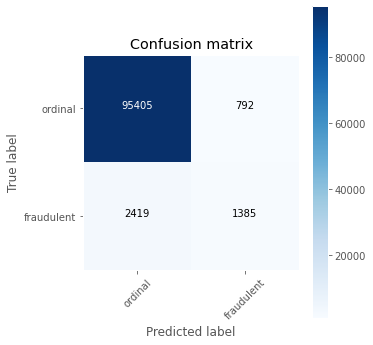

In [148]:
cnf_matrix = confusion_matrix(test_target, lb_score>=threshold)
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['ordinal', 'fraudulent'], normalize=False, title='Confusion matrix',)
plt.show()

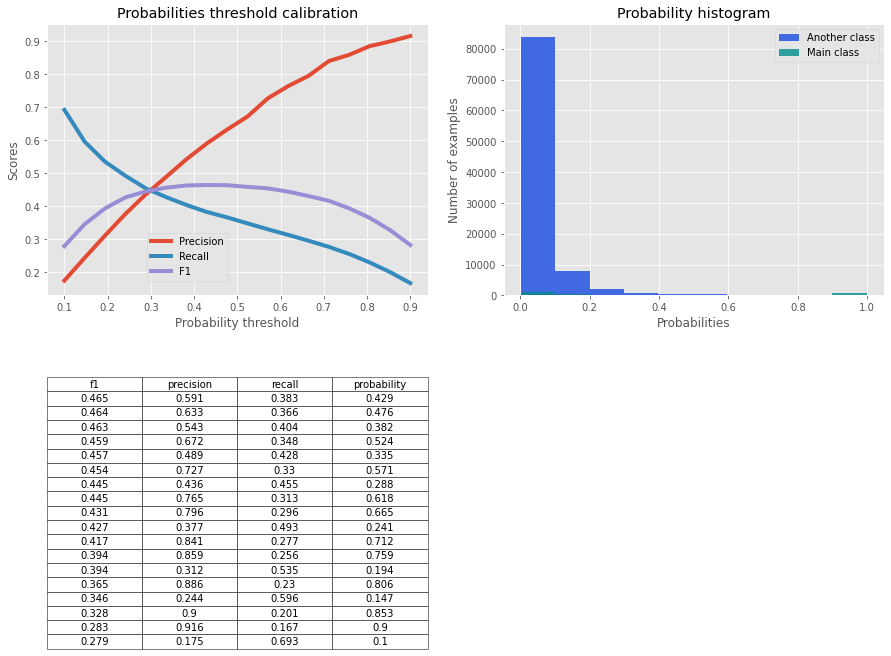

In [149]:
show_proba_calibration_plots(lb_score, test_target)

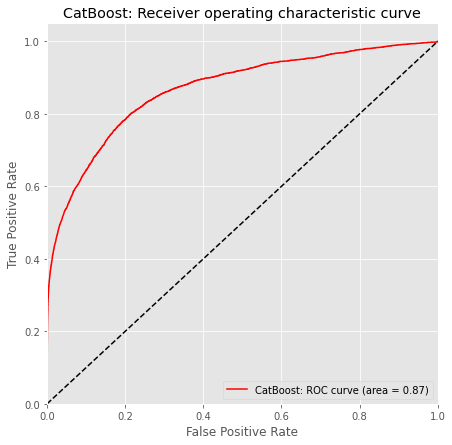

In [154]:
fpr, tpr, roc_thresholds = roc_curve(test_target, lb_score)
precision, recall, pr_thresholds = precision_recall_curve(test_target, lb_score)

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "CatBoost", color='r')

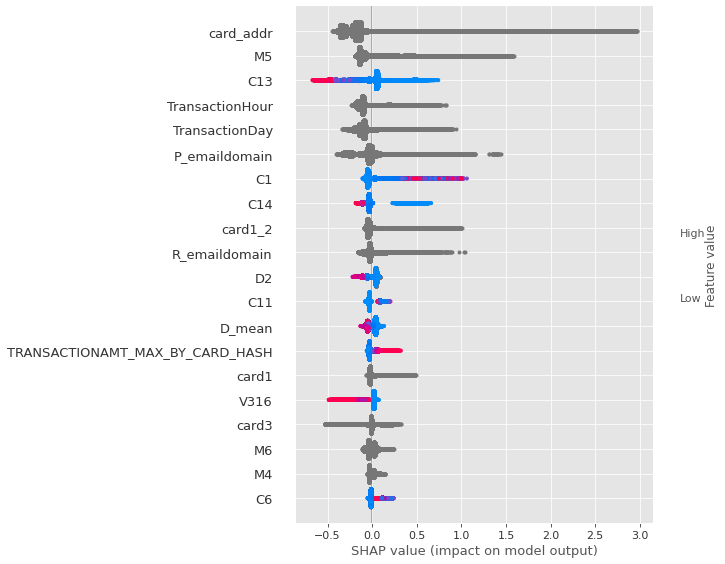

In [158]:
shap_values = model.get_feature_importance(train_pool, type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.summary_plot(shap_values, x_train)

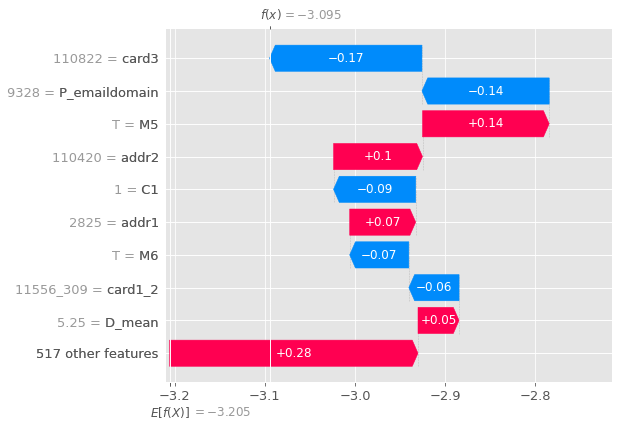

In [162]:
idx = 3
explainer = shap.TreeExplainer(model)
shap_values_one = explainer(test_data.iloc[idx:idx+1])
shap.plots.waterfall(shap_values_one[0])

In [163]:
shap.force_plot(explainer.expected_value, shap_values[0], feature_names=x_train.columns, features=test_data.iloc[idx:idx+1],
                link='logit')